In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df_train = pd.read_csv(r'C:\Users\thoma\Desktop\Diffusion\Wavelet Diff\data\Training Data\bitcoin_raw_prices_train.csv')

In [3]:
df_test = pd.read_csv(r'C:\Users\thoma\Desktop\Diffusion\Wavelet Diff\data\Testing Data\bitcoin_raw_prices_test.csv')

In [6]:
df_all = pd.concat([df_train, df_test], ignore_index=True)

In [9]:
df_all['change'] = df_all['Close'].pct_change()

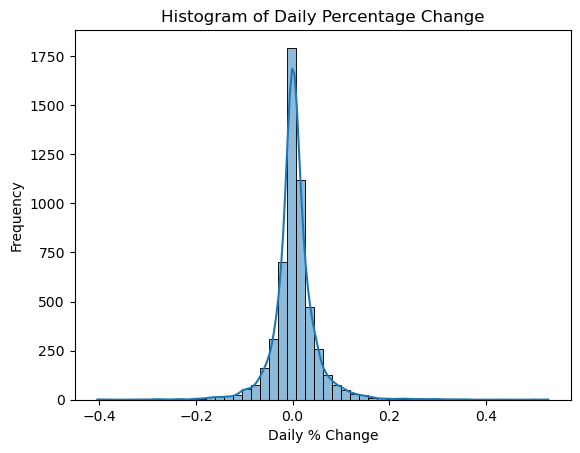

Normal test statistic: 1698.4462, p-value: 0
The distribution is likely not normal (reject H0).


In [11]:
from scipy import stats

# Plot histogram
sns.histplot(df_all['change'].dropna(), bins=50, kde=True)
plt.xlabel('Daily % Change')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Percentage Change')
plt.show()

# Normality test
stat, p = stats.normaltest(df_all['change'].dropna())
print(f"Normal test statistic: {stat:.4f}, p-value: {p:.4g}")
if p < 0.05:
    print("The distribution is likely not normal (reject H0).")
else:
    print("The distribution is likely normal (fail to reject H0).")

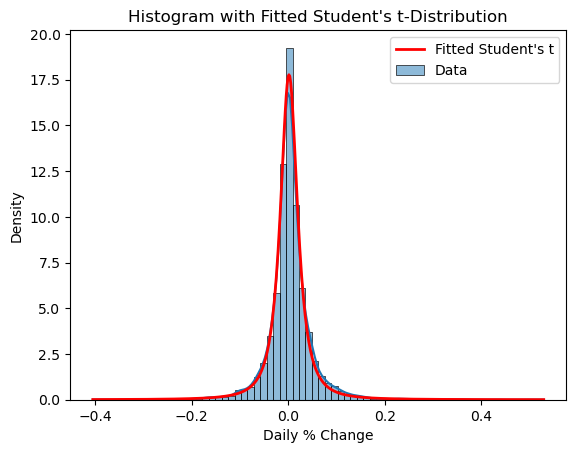

Fitted Student's t parameters: df=1.75, loc=0.0017, scale=0.0196


In [15]:
# Fit a Student's t-distribution to the 'change' data
change_data = df_all['change'].dropna()
t_params = stats.t.fit(change_data)

# Plot histogram with fitted t-distribution
sns.histplot(change_data, bins=70, kde=True, stat='density', label='Data')
x = np.linspace(change_data.min(), change_data.max(), 500)
pdf_t = stats.t.pdf(x, *t_params)
plt.plot(x, pdf_t, 'r-', lw=2, label="Fitted Student's t")
plt.xlabel('Daily % Change')
plt.ylabel('Density')
plt.title("Histogram with Fitted Student's t-Distribution")
plt.legend()
plt.show()

print(f"Fitted Student's t parameters: df={t_params[0]:.2f}, loc={t_params[1]:.4f}, scale={t_params[2]:.4f}")

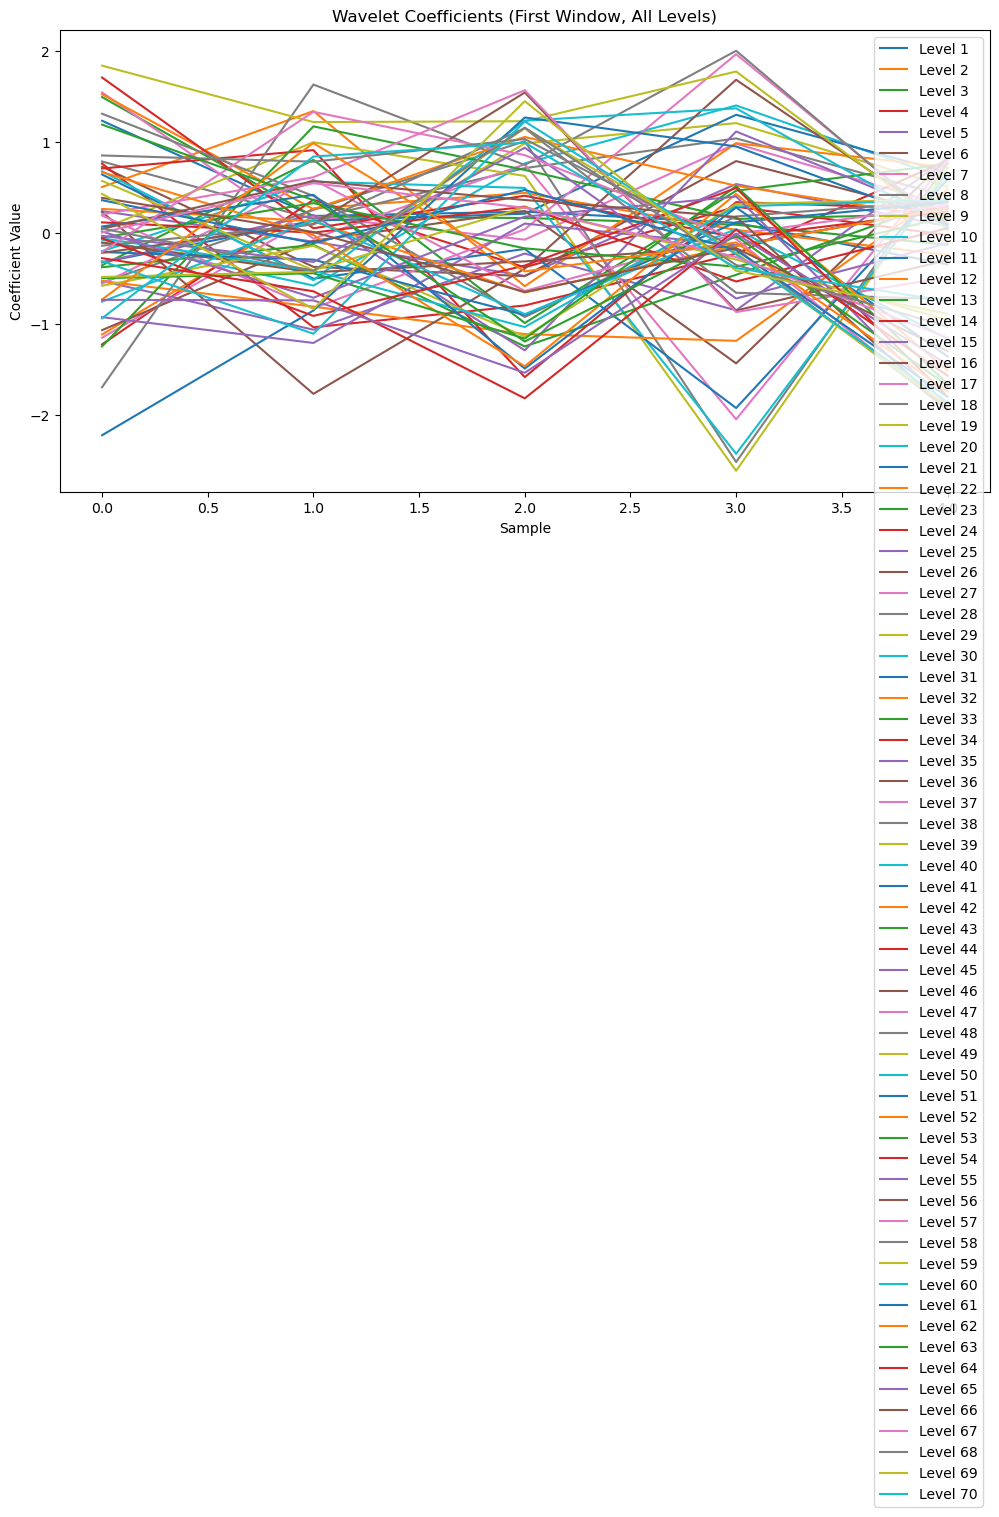

In [3]:
import torch

# Load the wavelet coefficients
coeffs = torch.load(r'C:\Users\thoma\Desktop\Diffusion\Wavelet Diff\data\wavelets\test wavelet\level4_swt_test_windows_norm.pt')

# Convert to numpy for plotting if needed
coeffs_np = coeffs.numpy()

# Plot the first window's coefficients for each level
plt.figure(figsize=(12, 6))
for i in range(coeffs_np.shape[1]):  # assuming shape is (num_windows, num_levels, window_length)
    plt.plot(coeffs_np[0, i], label=f'Level {i+1}')
plt.title('Wavelet Coefficients (First Window, All Levels)')
plt.xlabel('Sample')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

In [ ]:
# Reconstruct the original sequence from the rolling windows (stride=1, window_length=70)
# We'll use the first column of each window to reconstruct, except for the last window, where we take all columns

window_length = coeffs_np.shape[1]
num_windows = coeffs_np.shape[0]
feature_dim = coeffs_np.shape[2]

# Initialize the reconstructed sequence list
reconstructed = []

# Take the first column from each window except the last
for idx in range(num_windows - 1):
    reconstructed.append(coeffs_np[idx, 0])

# For the last window, take all columns
reconstructed.extend(coeffs_np[-1])

# Convert to numpy array
reconstructed_sequence = np.array(reconstructed)

# reconstructed_sequence shape: (num_windows - 1 + window_length, feature_dim)
print("Reconstructed sequence shape:", reconstructed_sequence.shape)

In [4]:
# Reconstruct the original sequence from the rolling windows (stride=1, window_length=70)
# We'll use the first column of each window to reconstruct, except for the last window, where we take all columns

window_length = coeffs_np.shape[1]
num_windows = coeffs_np.shape[0]
feature_dim = coeffs_np.shape[2]

# Initialize the reconstructed sequence list
reconstructed = []

# Take the first column from each window except the last
for idx in range(num_windows - 1):
    reconstructed.append(coeffs_np[idx, 0])

# For the last window, take all columns
reconstructed.extend(coeffs_np[-1])

# Convert to numpy array
reconstructed_sequence = np.array(reconstructed)

# reconstructed_sequence shape: (num_windows - 1 + window_length, feature_dim)
print("Reconstructed sequence shape:", reconstructed_sequence.shape)

Reconstructed sequence shape: (1077, 5)


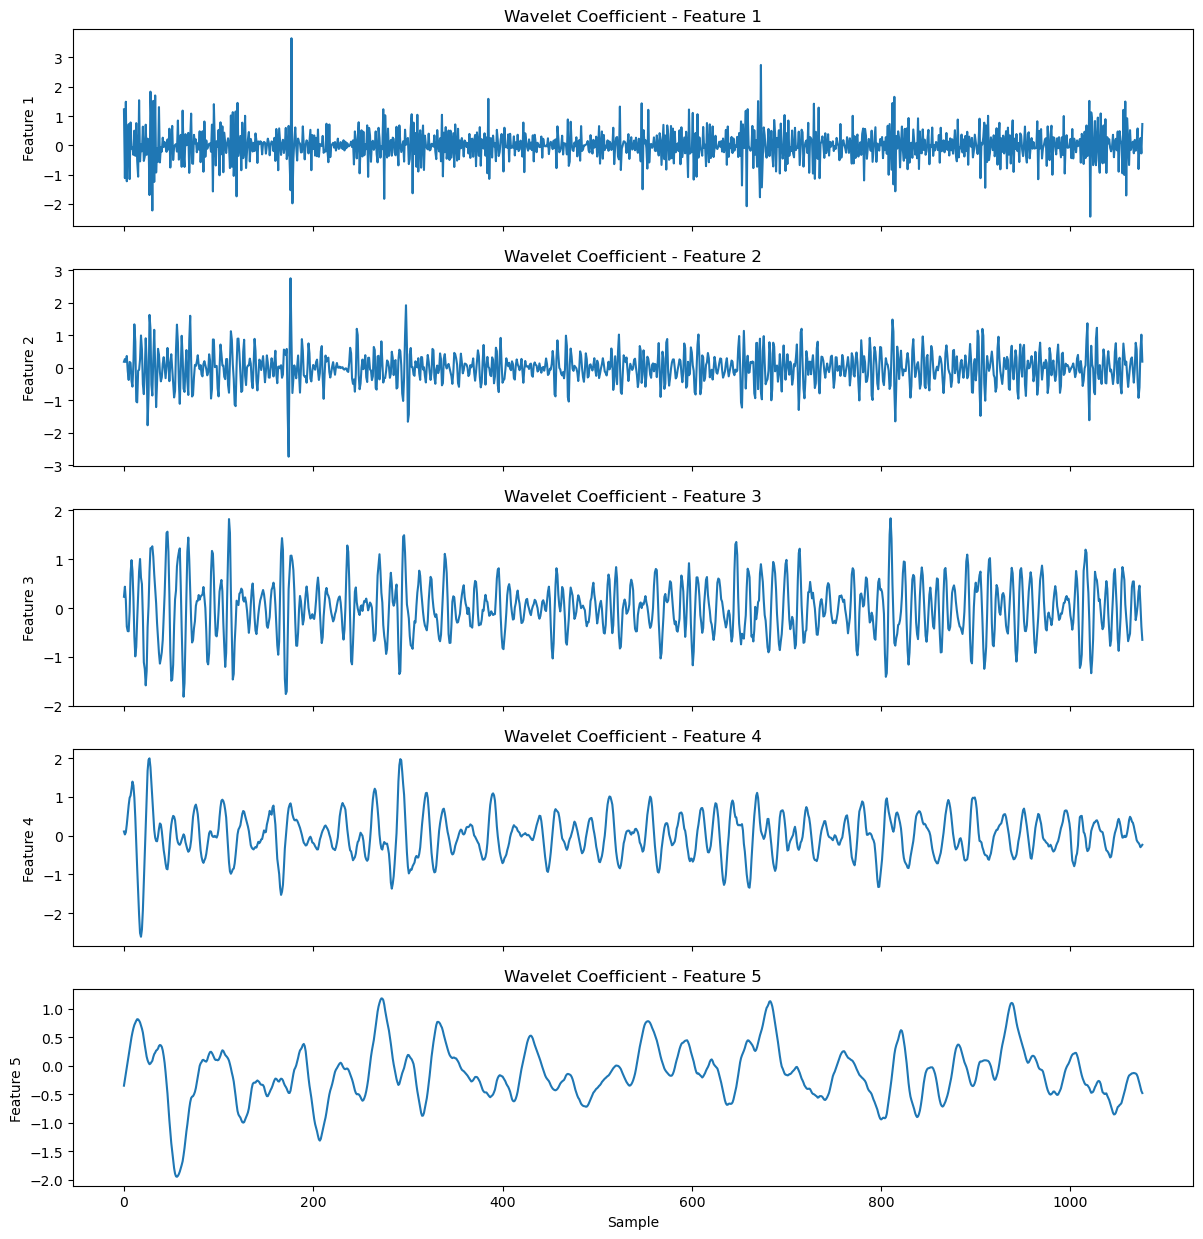

In [9]:
# Plot each feature in its own subplot
fig, axes = plt.subplots(feature_dim, 1, figsize=(12, 2.5 * feature_dim), sharex=True)

for f in range(feature_dim):
    axes[f].plot(reconstructed_sequence[:, f])
    axes[f].set_ylabel(f'Feature {f+1}')
    axes[f].set_title(f'Wavelet Coefficient - Feature {f+1}')

axes[-1].set_xlabel('Sample')
plt.tight_layout()
plt.show()

Reconstructed train sequence shape: (4306, 5)


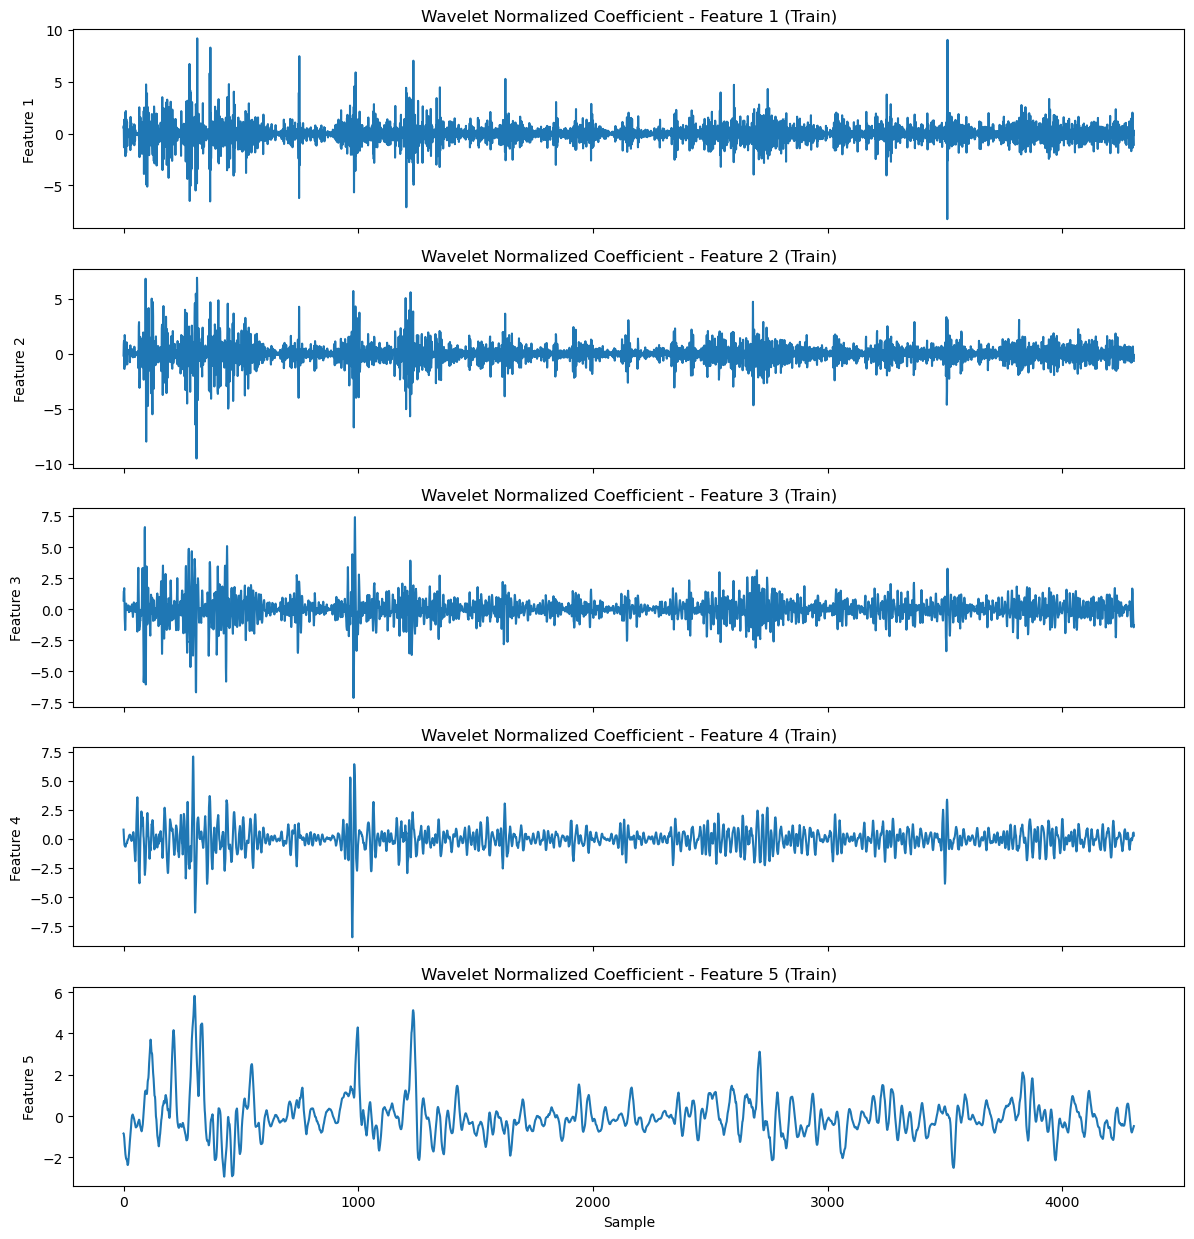

In [12]:
# Load the wavelet coefficients for the train data
coeffs_train = torch.load(r'C:\Users\thoma\Desktop\Diffusion\Wavelet Diff\data\wavelets\train wavelet\level4_swt_train_windows_norm.pt')
coeffs_train_np = coeffs_train.numpy()

# Reconstruct the original sequence from the rolling windows (stride=1, window_length=70)
window_length_train = coeffs_train_np.shape[1]
num_windows_train = coeffs_train_np.shape[0]
feature_dim_train = coeffs_train_np.shape[2]

reconstructed_train = []
for idx in range(num_windows_train - 1):
    reconstructed_train.append(coeffs_train_np[idx, 0])
reconstructed_train.extend(coeffs_train_np[-1])

reconstructed_sequence_train = np.array(reconstructed_train)
print("Reconstructed train sequence shape:", reconstructed_sequence_train.shape)

# Plot each feature in its own subplot
fig_train, axes_train = plt.subplots(feature_dim_train, 1, figsize=(12, 2.5 * feature_dim_train), sharex=True)
for f in range(feature_dim_train):
    axes_train[f].plot(reconstructed_sequence_train[:, f])
    axes_train[f].set_ylabel(f'Feature {f+1}')
    axes_train[f].set_title(f'Wavelet Normalized Coefficient - Feature {f+1} (Train)')
axes_train[-1].set_xlabel('Sample')
plt.tight_layout()
plt.show()

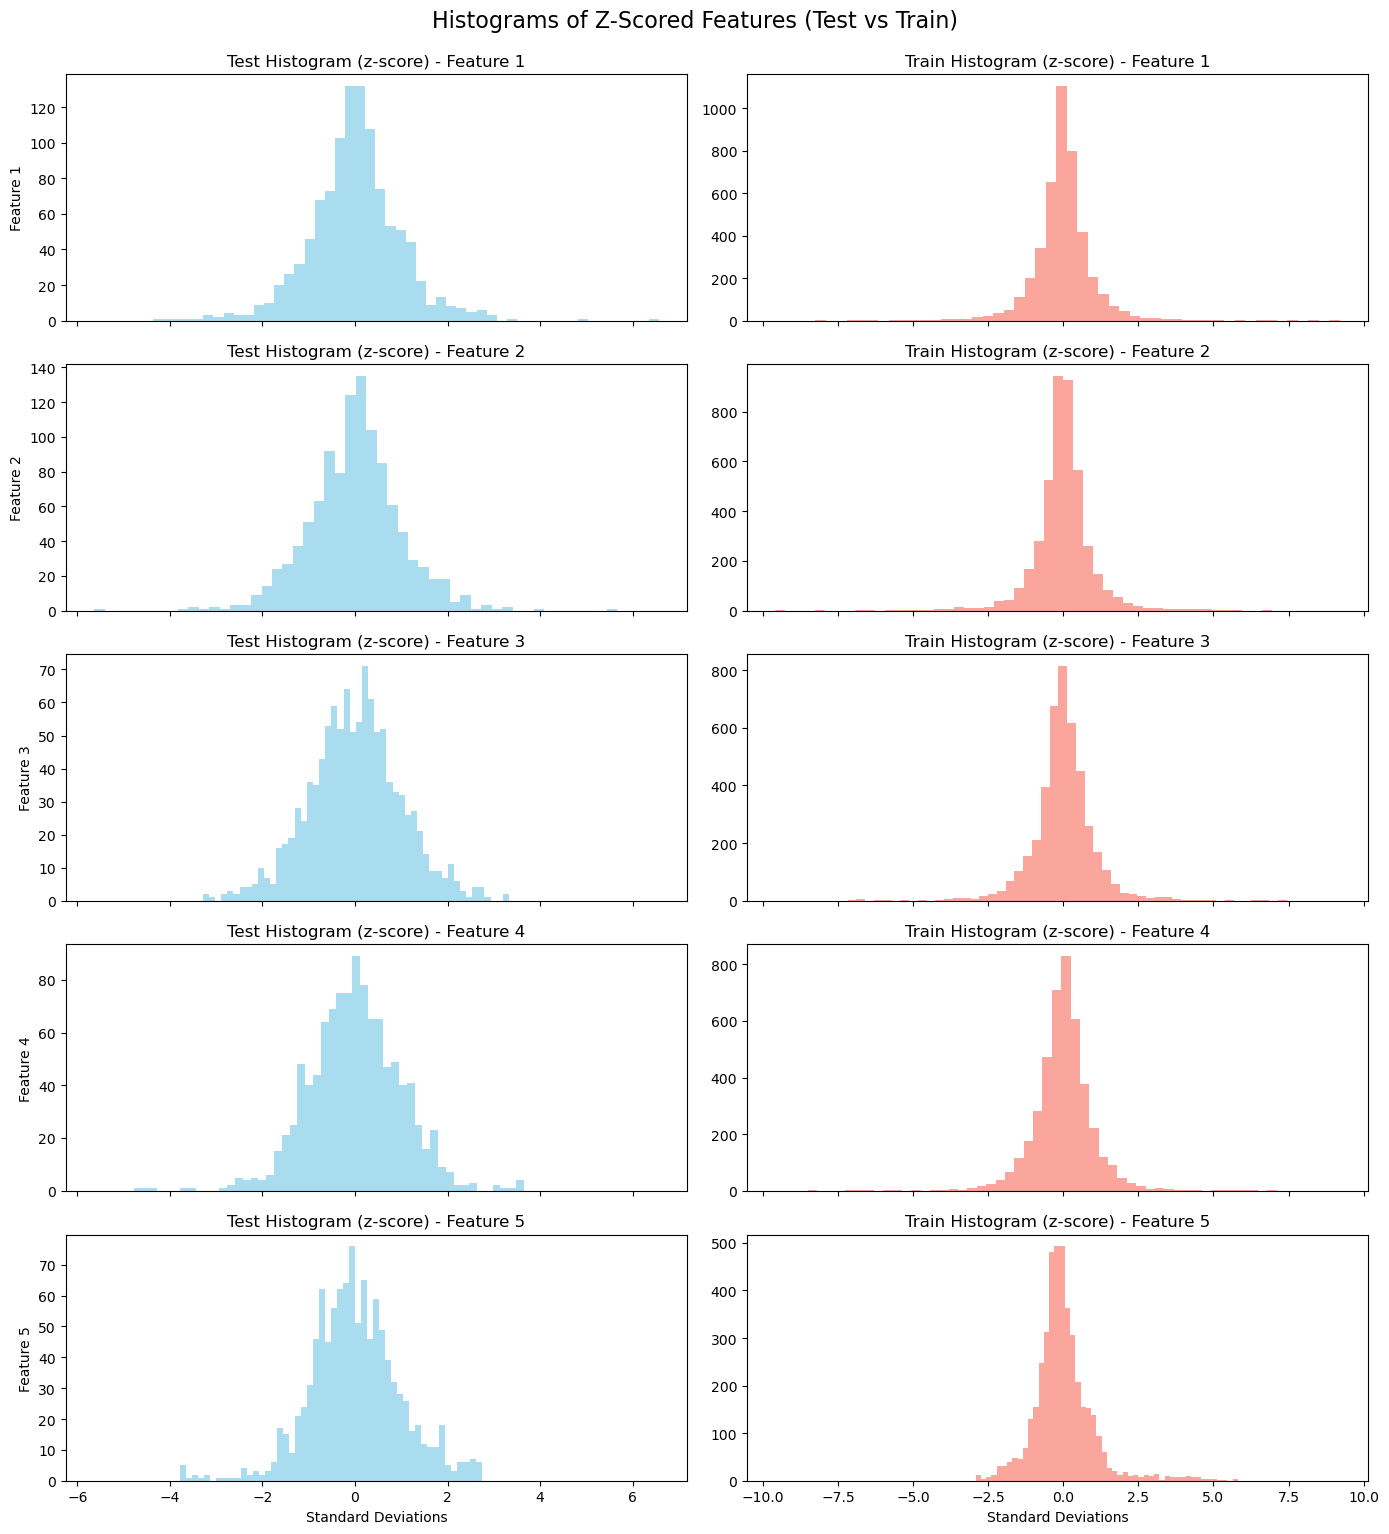

In [17]:
# Plot frequency histograms (z-scores) for each feature in the reconstructed test and train sequences
fig_hist, axes_hist = plt.subplots(feature_dim, 2, figsize=(14, 3 * feature_dim), sharex='col')

for f in range(feature_dim):
    # Standardize (z-score) the data
    test_z = (reconstructed_sequence[:, f] - np.mean(reconstructed_sequence[:, f])) / np.std(reconstructed_sequence[:, f])
    train_z = (reconstructed_sequence_train[:, f] - np.mean(reconstructed_sequence_train[:, f])) / np.std(reconstructed_sequence_train[:, f])
    # Test data histogram
    axes_hist[f, 0].hist(test_z, bins=50, color='skyblue', alpha=0.7)
    axes_hist[f, 0].set_ylabel(f'Feature {f+1}')
    axes_hist[f, 0].set_title(f'Test Histogram (z-score) - Feature {f+1}')
    # Train data histogram
    axes_hist[f, 1].hist(train_z, bins=50, color='salmon', alpha=0.7)
    axes_hist[f, 1].set_title(f'Train Histogram (z-score) - Feature {f+1}')

axes_hist[-1, 0].set_xlabel('Standard Deviations')
axes_hist[-1, 1].set_xlabel('Standard Deviations')
plt.tight_layout()
plt.suptitle("Histograms of Z-Scored Features (Test vs Train)", fontsize=16, y=1.02)
for ax_row, feat_num in zip(axes_hist, range(1, feature_dim + 1)):
    ax_row[0].set_ylabel(f'Feature {feat_num}')